# NN from scratch

In [1]:
import numpy as np
from numpy import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
class Layer:
    def forward(self, x):
        raise NotImplementedError()
    def backward(self, out_grad, lr):
        raise NotImplementedError()
    def __call__(self, *args):
        return self.forward(*args)

## Dense Layer
### Forward

$$Y = WX + B$$

### Backward

- The new out_grad:

$$\frac{\partial E}{\partial X}= W^T \frac{\partial E}{\partial Y}$$

- The new weight_grad:
$$
\frac{\partial E}{\partial W} = \frac{\partial E}{\partial Y}X^T
$$
- The new bias_grad:
$$
\frac{\partial E}{\partial W} = mean\Bigg(\frac{\partial E}{\partial Y}, axis=1\Bigg)
$$

In [13]:
# Dense Layer
class Linear(Layer):
    def __init__(self, in_size, out_size) -> None:
        # initializes the trainable parameters of this layer
        self.weights = random.randn(out_size, in_size) * np.sqrt(1/in_size)
        self.bias = random.randn(out_size, 1) * np.sqrt(1/in_size)

    def forward(self, x):
        self.x = x      # to be used in BKW propagation
        return self.weights @ x + self.bias
    
    def backward(self, out_grad, lr):
        new_out_grad = self.weights.T @ out_grad
        grad_w = out_grad @ self.x.T
        grad_b = np.mean(out_grad, axis=1).reshape(-1,1)

        self.weights -= lr * grad_w
        self.bias -= lr * grad_b

        return new_out_grad

## Activation Layer
### Forward
$$Y = f(X)$$

#### RelU:
<img src="relu.png" width="300">

$$\operatorname{RelU}(x)= \begin{cases}0, & x \leq 0 \\ x, & x>0\end{cases}$$


### Backward
$$
\frac{\partial E}{\partial X} = \frac{\partial E}{\partial Y} \odot f'(X)
$$

$$\operatorname{RelU'}(x)= \begin{cases}0, & x < 0 \\ 1, & x>0\end{cases}$$

In [4]:
class RelU(Layer):
    def __init__(self) -> None:
        None
    
    def forward(self, x):
        self.x = x
        return np.maximum(x,0)

    def backward(self, out_grad, lr):
        Relu_prime = (self.x > 0).astype(int)
        #Relu_prime = np.where(self.x > 0, 1, 0)

        return np.multiply(Relu_prime, out_grad)

## Loss
### MSE

$$E = \frac{1}{n}\sum_{i=1}^{n}(\hat{y}_i - y_i)^2$$

### MSE Gradient

$$\frac{\partial E}{\partial Y} = \frac{2}{nm}(\hat{Y} - Y)$$

In [5]:
class MSE:
    def loss(self, y, y_true):
        return np.mean((y-y_true)**2)
    
    def loss_grad(self, y, y_true):
        no_classes = y.shape[0]
        no_datapoints = y.shape[1]
        return (2/(no_classes*no_datapoints)) * (y-y_true)

In [6]:
class NN:
    def __init__(self, x, y, layers_dim, lr, max_iterations, activation=RelU, loss=MSE):
        self.x = x.T
        self.y = y.T
        self.loss = loss
        self.lr = lr
        self.max_iterations = max_iterations
        self.network = []
        self.initialize_network(layers_dim, activation)
    
    def initialize_network(self, layers_dim, activation) -> None:
        assert layers_dim[0] == self.x.shape[0], f"The input layer must be of size {self.x.shape[0]}"
        assert layers_dim[-1] == self.y.shape[0], f"The output layer must be of size {self.y.shape[0]}"

        for i in range(len(layers_dim) - 1):
            self.network.extend(
                [ Linear(layers_dim[i], layers_dim[i+1]), activation() ]
                 )
            
    def forward(self):
        output = self.x
        for layer in self.network:
            output = layer(output)

        return output
    
    def backward(self, y_pred):
        out_grad = self.loss.loss_grad(self, y_pred, self.y)
        for layer in reversed(self.network):
            out_grad = layer.backward(out_grad, self.lr)
        
        return out_grad
    
    def train(self) -> None:
        for epoch in range(self.max_iterations):
            y_pred = self.forward()
            loss = self.loss.loss(self, y_pred, self.y)
            acc = calculate_accuracy(y_pred, self.y)
            self.backward(y_pred)
            print(f"Epoch {epoch}/{self.max_iterations}: Loss = {loss}, acc = {acc*100:.2f}%")

    def predict(self, x):
        output = x
        for layer in self.network:
            output = layer(output)
        return output


In [7]:
def calculate_accuracy(y_pred, y_true):
    pred_labels = np.argmax(y_pred, axis=0)
    true_labels = np.argmax(y_true, axis=0)
    return np.mean(pred_labels == true_labels)

In [8]:
from tensorflow.keras.datasets import mnist
mnist_dataset = mnist.load_data()

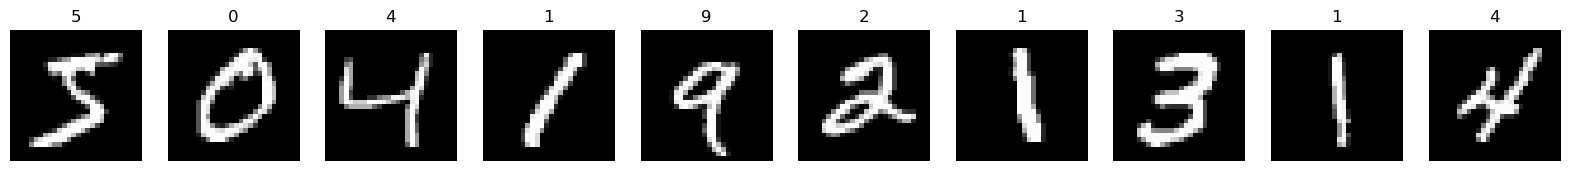

In [3]:
# the 10 classes of the mnist dataset
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 10, figsize=(20, 20))
for i in range(10):
    ax[i].imshow(mnist_dataset[0][0][i], cmap='gray')
    ax[i].set_title(mnist_dataset[0][1][i])
    ax[i].axis('off')
plt.show()

In [16]:
X = mnist_dataset[0][0].reshape(60000, 784) / 255       # flatten, normalize
y = mnist_dataset[0][1]
y_one_hot = np.eye(10)[y]                       # one hot encode the target labels

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

X_train_normalized = X_train_normalized
X_test_normalized = X_test_normalized.T
y_train = y_train
y_test = y_test.T

layers_dim = [784,64,10]
lr = 0.6   # Learning rate
activation_layer = RelU
loss = MSE
enable_bias = True

nn = NN(X_train_normalized, y_train, layers_dim, lr, 400, activation_layer, loss)
nn.train()
y_pred = nn.predict(X_test_normalized)

# Calculate the accuracy of the model with the test data
accuracy = calculate_accuracy(y_pred, y_test)
print("==========================================")
print(f"Test data Accuracy: {accuracy * 100:.2f}%")

Epoch 0/400: Loss = 0.2846639373637039, acc = 11.15%
Epoch 1/400: Loss = 0.11809815605841975, acc = 19.70%
Epoch 2/400: Loss = 0.10142902910964072, acc = 26.11%
Epoch 3/400: Loss = 0.0927505710212492, acc = 31.45%
Epoch 4/400: Loss = 0.08610758778771775, acc = 37.25%
Epoch 5/400: Loss = 0.07971651765457125, acc = 42.70%
Epoch 6/400: Loss = 0.07431001070081748, acc = 46.57%
Epoch 7/400: Loss = 0.07026317774556601, acc = 49.58%
Epoch 8/400: Loss = 0.06698661412097306, acc = 52.29%
Epoch 9/400: Loss = 0.06410933240115749, acc = 54.81%
Epoch 10/400: Loss = 0.06139162470516078, acc = 57.31%
Epoch 11/400: Loss = 0.05875152872500929, acc = 59.81%
Epoch 12/400: Loss = 0.05621395068075168, acc = 62.16%
Epoch 13/400: Loss = 0.053976719535976055, acc = 64.23%
Epoch 14/400: Loss = 0.05213136346548588, acc = 65.76%
Epoch 15/400: Loss = 0.05061901214115518, acc = 67.06%
Epoch 16/400: Loss = 0.049341894449383986, acc = 68.07%
Epoch 17/400: Loss = 0.04822864069860058, acc = 68.96%
Epoch 18/400: Loss =